In [2]:
!pip install numpy pandas matplotlib scikit-learn tensorflow yfinance

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [3]:
# Define the stock ticker and timeframe
stock_ticker = "AAPL"  # Apple Inc.
start_date = "2015-01-01"
end_date = "2024-01-01"

# Download data
df = yf.download(stock_ticker, start=start_date, end=end_date)
df = df[['Close']]  # Keep only the closing price
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2015-01-02,24.320429
2015-01-05,23.635288
2015-01-06,23.637510
2015-01-07,23.968960
2015-01-08,24.889900


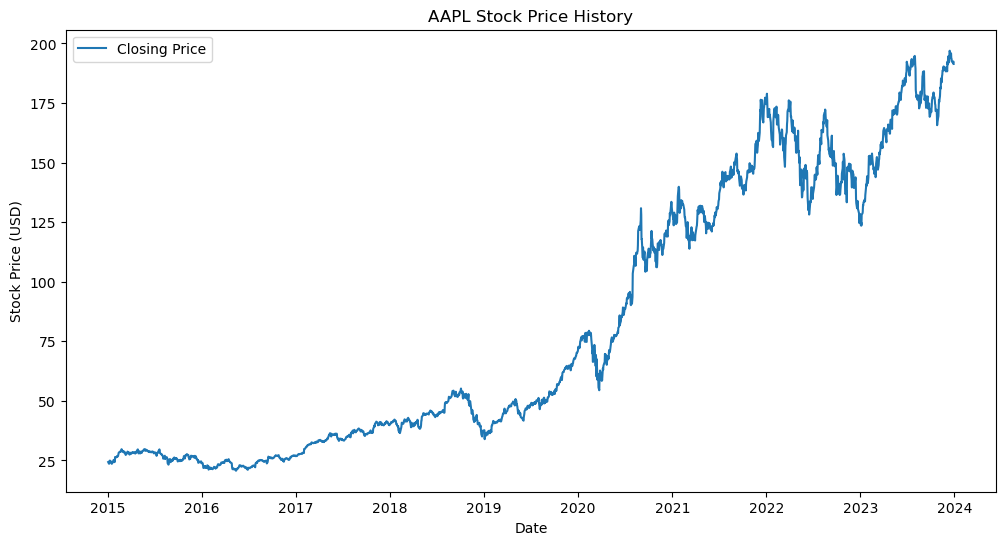

In [5]:
plt.figure(figsize=(12,6))
plt.plot(df, label="Closing Price")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.title(f"{stock_ticker} Stock Price History")
plt.legend()
plt.show()

In [6]:
# Create a feature 'Days' representing the number of days from the start
df['Days'] = np.arange(len(df))

# Define features and labels
X = df[['Days']].values  # Independent variable (Days)
y = df[['Close']].values  # Dependent variable (Stock price)

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

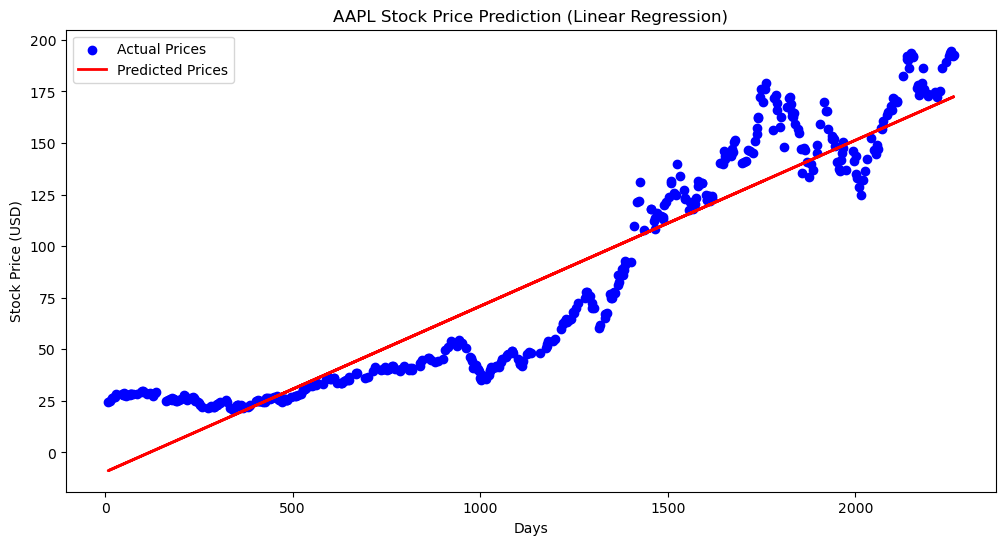

In [7]:
# Initialize and train the model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict prices
y_pred = linear_model.predict(X_test)

# Plot the results
plt.figure(figsize=(12,6))
plt.scatter(X_test, y_test, color='blue', label='Actual Prices')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted Prices')
plt.xlabel("Days")
plt.ylabel("Stock Price (USD)")
plt.title(f"{stock_ticker} Stock Price Prediction (Linear Regression)")
plt.legend()
plt.show()

In [8]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])

# Create sequences for LSTM (Using past 60 days to predict next)
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step, 0])
        y.append(data[i+time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_lstm, y_lstm = create_sequences(scaled_data, time_step)

# Reshape for LSTM (samples, time steps, features)
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

# Split data
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

In [9]:
# Build LSTM Model
lstm_model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train_lstm, y_train_lstm, batch_size=16, epochs=20, validation_data=(X_test_lstm, y_test_lstm))

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0304 - val_loss: 6.2020e-04
Epoch 2/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0033 - val_loss: 5.7372e-04
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0021 - val_loss: 7.6924e-04
Epoch 4/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0020 - val_loss: 4.7800e-04
Epoch 5/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 6/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 7/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0015 - val_loss: 4.5029e-04
Epoch 8/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0013 - val_loss: 6.9345e-04
Epoch 9/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 10/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0023 - val_loss: 5.3889e-04
Epoch 11/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0013 - val_loss: 8.9769e-04
Epoch 12/20
111/111 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


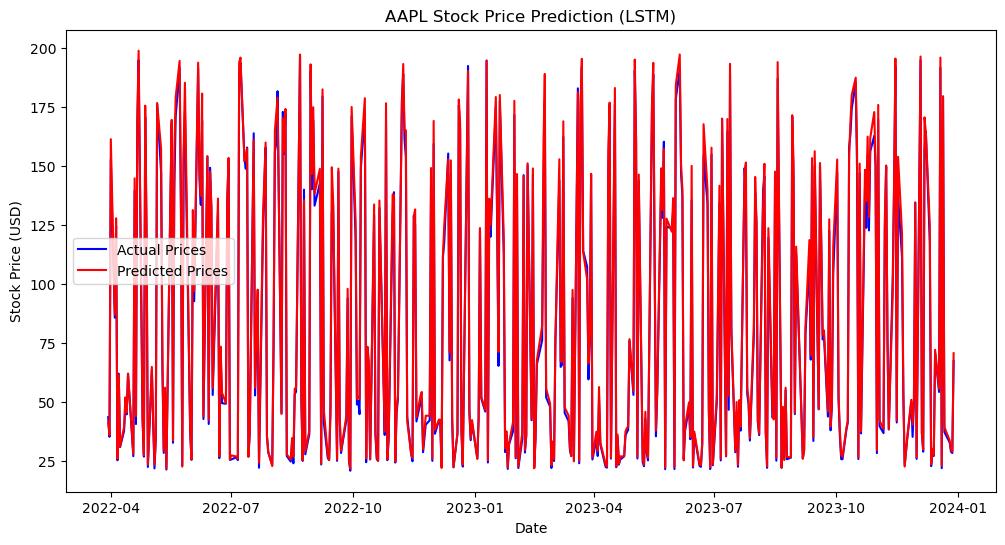

In [10]:
# Predict stock prices
predicted_stock_price = lstm_model.predict(X_test_lstm)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price.reshape(-1, 1))

# Plot results
plt.figure(figsize=(12,6))
plt.plot(df.index[-len(y_test_lstm):], scaler.inverse_transform(y_test_lstm.reshape(-1, 1)), color='blue', label='Actual Prices')
plt.plot(df.index[-len(y_test_lstm):], predicted_stock_price, color='red', label='Predicted Prices')
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.title(f"{stock_ticker} Stock Price Prediction (LSTM)")
plt.legend()
plt.show()

In [11]:
import joblib
linear_model_filename = "linear_model.pkl"
joblib.dump(linear_model, linear_model_filename)

lstm_model.save("lstm_model.h5")

In [12]:
# Load Linear Regression Model
loaded_linear_model = joblib.load(linear_model_filename)

# Load LSTM Model
from tensorflow.keras.models import load_model
loaded_lstm_model = load_model("lstm_model.h5")